## installing necessary libraries

In [2]:
!pip install easyfsl

### importing necessary libraries

In [3]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR100 ##Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

Let's take some time to grasp what few-shot classification is. Simply put, in a few-shot classification task, you have a labeled support set (which kind of acts
like a catalog) and query set. For each image of the query set, we want to predict a label from the
labels present in the support set. A few-shot classification model has to use the information from the
support set in order to classify query images. We say *few-shot* when the support set contains very
few images for each label (typically less than 10). The figure below shows a 3-way 2-shots classification task. "3-way" means "3 different classes" and "2-shots" means "2 examples per class".
We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully
predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard,
a Pug or a Labrador can be.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Most few-shot classification methods are *metric-based*. It works in two phases : 1) they use a CNN to project both
support and query images into a feature space, and 2) they classify query images by comparing them to support images.
If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that
it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function that takes an image as input and outputs a representation (or *embedding*) of this image in a given feature space. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.



1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [4]:
image_size = 224

train_set = CIFAR100(
    root="./data",
    transform=transforms.Compose(
        [
            # transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = CIFAR100(
    root="./data",
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
train_set.get_labels = lambda: train_set._labels
test_set.idx_to_class = {idx: cl for cl, idx in test_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools).We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).

In [5]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
#print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [6]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

test_set.get_labels = lambda: test_set.targets

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    y_pred = torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
    return y_pred

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    f1_scores = []

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in enumerate(data_loader):

            y_pred = evaluate_on_one_task(
                support_images, support_labels, query_images,
            )
            total_predictions += len(query_labels)
            correct_predictions += (y_pred == query_labels.cuda()).sum().item()
            f1_scores.append(f1_score(query_labels.cpu(), y_pred.cpu(), average='macro'))

    accuracy = (correct_predictions/total_predictions)
    avg_f1 = sum(f1_scores)/len(f1_scores)
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2%}, F1: {avg_f1}"
    )

    return accuracy
# evaluate(test_loader)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).

[33, 72, 17, 19, 60]
<generator object <genexpr> at 0x7e53a3f334c0>


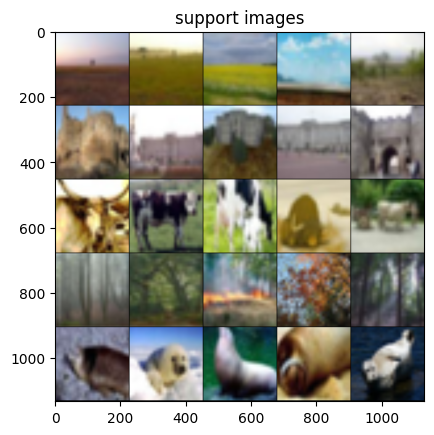

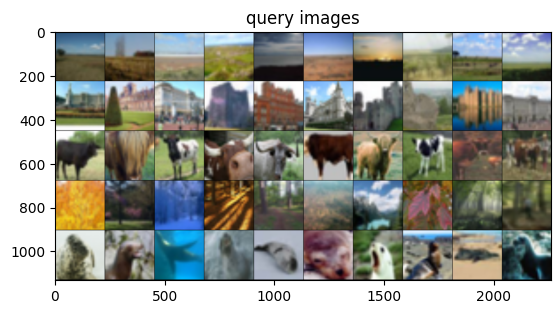

In [8]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

print(example_class_ids)
print(test_set.idx_to_class[i] for i in list(example_class_ids))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

In [9]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

##
# print(example_scores.shape)
# print(torch.softmax(example_scores, dim=1) )

##
print("Some example predictions on query images:")
print("Ground Truth - Predicted")
print("________________________")
for i in range(len(example_query_labels)):
    print(
        # f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
        f"{test_set.idx_to_class[example_class_ids[example_query_labels[i]]]} - {test_set.idx_to_class[example_class_ids[example_predicted_labels[i]]]}"
    )

Some example predictions on query images:
Ground Truth - Predicted
________________________
plain - plain
plain - castle
plain - plain
plain - plain
plain - plain
plain - plain
plain - plain
plain - plain
plain - plain
plain - plain
castle - plain
castle - cattle
castle - castle
castle - castle
castle - castle
castle - cattle
castle - castle
castle - castle
castle - castle
castle - castle
cattle - cattle
cattle - cattle
cattle - cattle
cattle - seal
cattle - cattle
cattle - seal
cattle - cattle
cattle - cattle
cattle - plain
cattle - castle
forest - plain
forest - forest
forest - forest
forest - forest
forest - forest
forest - plain
forest - cattle
forest - plain
forest - forest
forest - forest
seal - seal
seal - seal
seal - forest
seal - castle
seal - seal
seal - seal
seal - cattle
seal - cattle
seal - plain
seal - cattle


In [10]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    y_pred = torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
    return y_pred

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    f1_scores = []

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in enumerate(data_loader):

            y_pred = evaluate_on_one_task(
                support_images, support_labels, query_images,
            )
            total_predictions += len(query_labels)
            correct_predictions += (y_pred == query_labels.cuda()).sum().item()
            f1_scores.append(f1_score(query_labels.cpu(), y_pred.cpu(), average='macro'))

    accuracy = (correct_predictions/total_predictions)
    avg_f1 = sum(f1_scores)/len(f1_scores)
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2%}, F1: {avg_f1}"
    )

    return accuracy
# evaluate(test_loader)

## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.



In [12]:
N_TRAINING_EPISODES = 60000
N_VALIDATION_TASKS = 100
train_set.get_labels = lambda: train_set.targets

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()



To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks, and let the fit method update our model after each task. This is called episodic training.

In [14]:
log_update_frequency = 100
acc_update_frequency = 500


all_loss = []
all_acc = []

model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:

    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
        # if episode_index % acc_update_frequency == 0:
        #     all_acc.append(evaluate(test_loader))
        #     model.train()

100%|██████████| 60000/60000 [3:46:17<00:00,  4.42it/s, loss=0.316]  


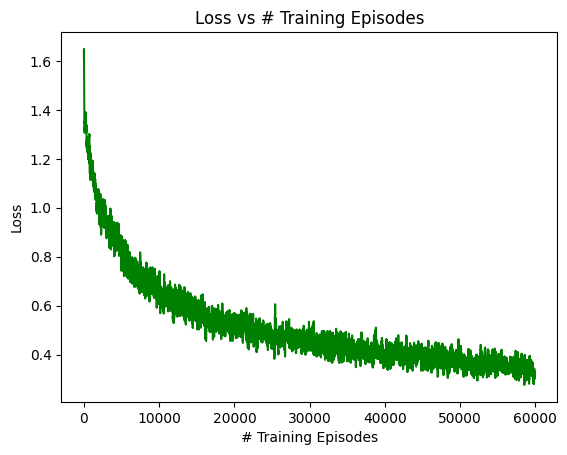

In [15]:
window_width = 50
cumsum_vec = np.cumsum(np.insert(all_loss, 0, 0))
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.title("Loss vs # Training Episodes")
plt.xlabel("# Training Episodes")
plt.ylabel("Loss")
plt.plot(ma_vec, color = "green")
plt.show()

In [16]:
evaluate(test_loader)

Model tested on 100 tasks. Accuracy: 95.02%, F1: 0.9490567191890382


0.9502